<h2 align="center">EDA_Details</h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sn

pd.set_option('display.max_columns', None)

In [2]:
sra_data = pd.read_csv("/Users/jihok/Documents/SraRunTable.csv")
# sra_data = pd.read_csv("/datasets/srp073813/reference/SraRunTable.csv")


In [3]:
sra_data = sra_data.drop(["Assay Type", "AvgSpotLen", "BioProject", "Center Name",
                            "Consent", "Instrument", "LibrarySource", "LibraryLayout", "LibrarySelection"
                            , "Organism", "Platform", "TISSUE"], axis=1)
sra_data

,Run,age_at_death,Bases,BioSample,Brain_pH,brain_region,Bytes,clinical_diagnosis,DATASTORE filetype,DATASTORE provider,DATASTORE region,ETHNICITY,Experiment,gender,GEO_Accession (exp),post-mortem_interval,ReleaseDate,Sample Name,source_name,SRA Study
0,SRR3438555,40,4177603300,SAMN04901133,6.76,AnCg,2585349730,Control,"fastq,sra","s3,ncbi,gs","ncbi.public,s3.us-east-1,gs.US",Caucasian,SRX1725699,male,GSM2132201,12.25,2017-06-25T00:00:00Z,GSM2132201,AnCg_Control,SRP073813
1,SRR3438556,58,4127971300,SAMN04901134,6.93,AnCg,2567182462,Major Depression,"fastq,sra","ncbi,s3,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725700,male,GSM2132202,24.00,2017-06-25T00:00:00Z,GSM2132202,AnCg_Major Depression,SRP073813
2,SRR3438557,56,4323572800,SAMN04901135,6.83,AnCg,2690248610,Bipolar Disorder,"sra,fastq","gs,s3,ncbi","s3.us-east-1,gs.US,ncbi.public",Caucasian,SRX1725701,female,GSM2132203,29.00,2017-06-25T00:00:00Z,GSM2132203,AnCg_Bipolar Disorder,SRP073813
3,SRR3438558,49,3092070200,SAMN04901136,7.19,AnCg,1915194552,Major Depression,"fastq,sra","s3,gs,ncbi","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725702,male,GSM2132204,27.00,2017-06-25T00:00:00Z,GSM2132204,AnCg_Major Depression,SRP073813
4,SRR3438559,31,5353395700,SAMN04901137,6.77,nAcc,3468863373,Schizophrenia,"fastq,sra","ncbi,s3,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725703,female,GSM2132205,22.00,2017-06-25T00:00:00Z,GSM2132205,nAcc_Schizophrenia,SRP073813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,SRR3438902,36,6163667000,SAMN04900948,6.82,nAcc,4019800174,Schizophrenia,"sra,fastq","s3,ncbi,gs","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725975,male,GSM2132477,11.20,2017-06-25T00:00:00Z,GSM2132477,nAcc_Schizophrenia,SRP073813
348,SRR3438903,52,6037220400,SAMN04900949,6.89,nAcc,3972125530,Schizophrenia,"sra,fastq","s3,ncbi,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725976,male,GSM2132478,23.50,2017-06-25T00:00:00Z,GSM2132478,nAcc_Schizophrenia,SRP073813
349,SRR3438904,50,10491339100,SAMN04900950,6.64,nAcc,7155187185,Schizophrenia,"sra,fastq","ncbi,s3,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725977,male,GSM2132479,25.70,2017-06-25T00:00:00Z,GSM2132479,nAcc_Schizophrenia,SRP073813
350,SRR3438905,55,11425517100,SAMN04900951,6.96,nAcc,7808616026,Schizophrenia,"sra,fastq","s3,ncbi,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725978,male,GSM2132480,12.00,2017-06-25T00:00:00Z,GSM2132480,nAcc_Schizophrenia,SRP073813


In [39]:
sra_data.round()

,Run,age_at_death,Bases,BioSample,Brain_pH,brain_region,Bytes,clinical_diagnosis,DATASTORE filetype,DATASTORE provider,DATASTORE region,ETHNICITY,Experiment,gender,GEO_Accession (exp),post-mortem_interval,ReleaseDate,Sample Name,source_name,SRA Study
0,SRR3438555,40,4177603300,SAMN04901133,7.0,AnCg,2585349730,Control,"fastq,sra","s3,ncbi,gs","ncbi.public,s3.us-east-1,gs.US",Caucasian,SRX1725699,male,GSM2132201,12.0,2017-06-25T00:00:00Z,GSM2132201,AnCg_Control,SRP073813
1,SRR3438556,58,4127971300,SAMN04901134,7.0,AnCg,2567182462,Major Depression,"fastq,sra","ncbi,s3,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725700,male,GSM2132202,24.0,2017-06-25T00:00:00Z,GSM2132202,AnCg_Major Depression,SRP073813
2,SRR3438557,56,4323572800,SAMN04901135,7.0,AnCg,2690248610,Bipolar Disorder,"sra,fastq","gs,s3,ncbi","s3.us-east-1,gs.US,ncbi.public",Caucasian,SRX1725701,female,GSM2132203,29.0,2017-06-25T00:00:00Z,GSM2132203,AnCg_Bipolar Disorder,SRP073813
3,SRR3438558,49,3092070200,SAMN04901136,7.0,AnCg,1915194552,Major Depression,"fastq,sra","s3,gs,ncbi","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725702,male,GSM2132204,27.0,2017-06-25T00:00:00Z,GSM2132204,AnCg_Major Depression,SRP073813
4,SRR3438559,31,5353395700,SAMN04901137,7.0,nAcc,3468863373,Schizophrenia,"fastq,sra","ncbi,s3,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725703,female,GSM2132205,22.0,2017-06-25T00:00:00Z,GSM2132205,nAcc_Schizophrenia,SRP073813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,SRR3438902,36,6163667000,SAMN04900948,7.0,nAcc,4019800174,Schizophrenia,"sra,fastq","s3,ncbi,gs","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725975,male,GSM2132477,11.0,2017-06-25T00:00:00Z,GSM2132477,nAcc_Schizophrenia,SRP073813
348,SRR3438903,52,6037220400,SAMN04900949,7.0,nAcc,3972125530,Schizophrenia,"sra,fastq","s3,ncbi,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725976,male,GSM2132478,24.0,2017-06-25T00:00:00Z,GSM2132478,nAcc_Schizophrenia,SRP073813
349,SRR3438904,50,10491339100,SAMN04900950,7.0,nAcc,7155187185,Schizophrenia,"sra,fastq","ncbi,s3,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725977,male,GSM2132479,26.0,2017-06-25T00:00:00Z,GSM2132479,nAcc_Schizophrenia,SRP073813
350,SRR3438905,55,11425517100,SAMN04900951,7.0,nAcc,7808616026,Schizophrenia,"sra,fastq","s3,ncbi,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725978,male,GSM2132480,12.0,2017-06-25T00:00:00Z,GSM2132480,nAcc_Schizophrenia,SRP073813


### Useful Terminology

post-mortem_interval (PMI) = the time (in hours) between patient death and when the body was found 

## General Population

In [4]:
sra_data['gender'].value_counts()

male      283
female     69
Name: gender, dtype: int64

In [36]:
# General Data Description
test = sra_data.describe().round()
test['Bases'] = test['Bases'].apply(lambda x: '%.5f' % x)
test['Bases']

count            352.00000
mean      5737179577.00000
std       2709876240.00000
min             1700.00000
25%       2937184400.00000
50%       5970290550.00000
75%       7928192300.00000
max      14810448900.00000
Name: Bases, dtype: object

In [37]:
# Data Description broken down by Gender and Clinical Diagnosis
gender_info = sra_data.groupby(['gender','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
gender_info = gender_info.unstack(level=0)
gender_info.round(3)

age_at_death         Brain_pH        post-mortem_interval  \
gender                   female    male   female   male               female   
clinical_diagnosis                                                             
Bipolar Disorder         49.111  48.950    6.745  6.838               20.291   
Control                  59.125  48.203    6.939  6.918               18.500   
Major Depression         50.478  43.014    7.072  7.027               24.257   
Schizophrenia            48.818  41.699    6.708  6.836               28.291   

                            
gender                male  
clinical_diagnosis          
Bipolar Disorder    22.834  
Control             22.316  
Major Depression    25.949  
Schizophrenia       20.478

### Age at Death and Brain_pH Histogram - General Population

Text(0, 0.5, 'Frequency')

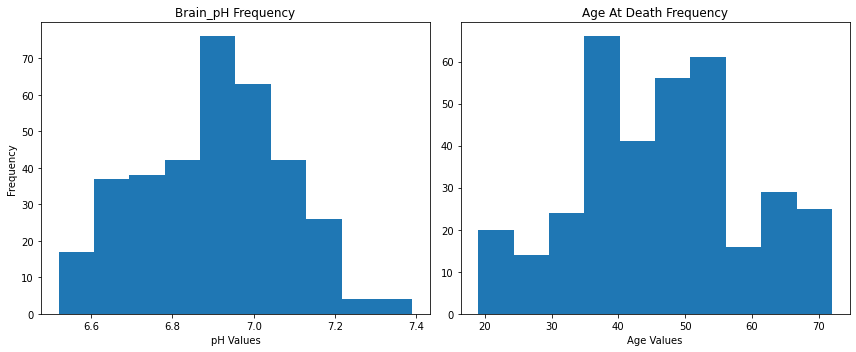

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

ax[0].hist(sra_data['Brain_pH'])
ax[1].hist(sra_data["age_at_death"])

ax[0].title.set_text("Brain_pH Frequency")
ax[1].title.set_text("Age At Death Frequency")

ax[0].set_xlabel("pH Values")
ax[1].set_xlabel("Age Values")

ax[0].set_ylabel("Frequency")
ax[0].set_ylabel("Frequency")

In [5]:
np.mean(sra_data['Brain_pH'])

6.900515759312322

In [6]:
np.mean(sra_data['age_at_death'])

46.42045454545455

### Age at Death Boxplot

Text(0.5, 0, 'Bipolar Disorder Patients')

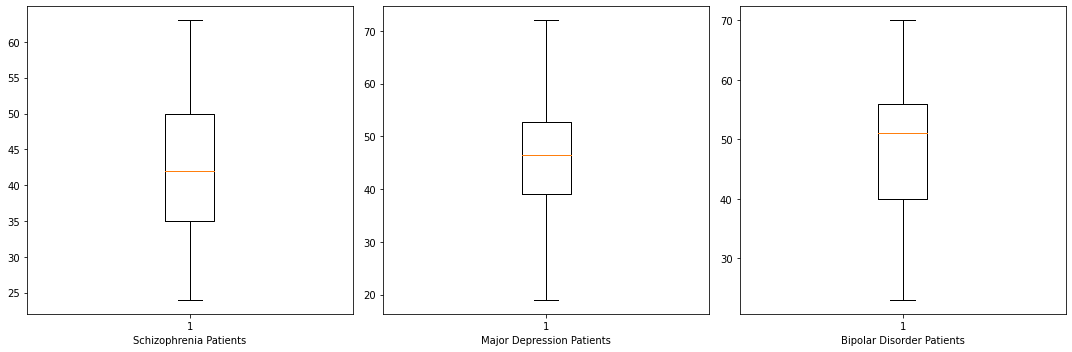

In [40]:
fig, ax = plt.subplots(1,3, figsize=(15,5),tight_layout=True)

all_scz = sra_data.loc[sra_data['clinical_diagnosis'] == 'Schizophrenia']
all_mdd = sra_data.loc[sra_data['clinical_diagnosis'] == 'Major Depression']
all_bpd = sra_data.loc[sra_data['clinical_diagnosis'] == 'Bipolar Disorder']
all_ctl = sra_data.loc[sra_data['clinical_diagnosis'] == 'Control']


ax[0].boxplot(all_scz['age_at_death'])
ax[1].boxplot(all_mdd['age_at_death'])
ax[2].boxplot(all_bpd['age_at_death'])

ax[0].set_xlabel("Schizophrenia Patients")
ax[1].set_xlabel("Major Depression Patients")
ax[2].set_xlabel("Bipolar Disorder Patients")

In [41]:
all_scz['age_at_death'].mean()

42.63095238095238

In [43]:
all_bpd['age_at_death'].mean()

49.0

In [42]:
all_mdd['age_at_death'].mean()

44.840425531914896

### 

Text(0, 0.5, 'Brain_pH')

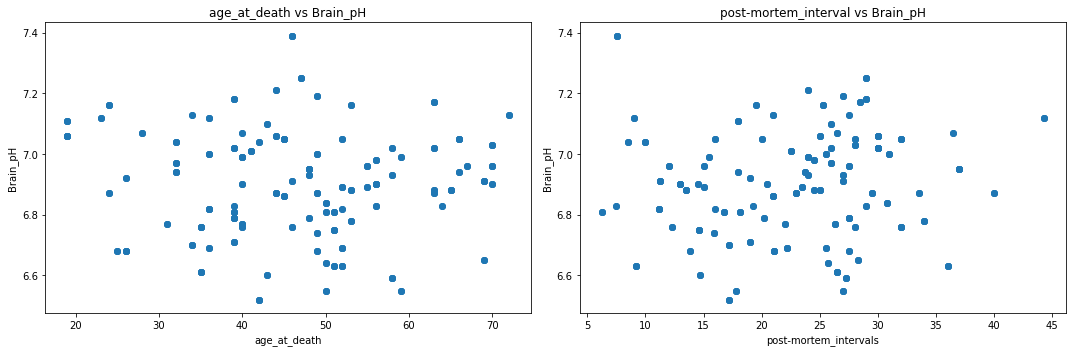

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5),tight_layout=True)

x_val_1 = sra_data['age_at_death']
y_val_1 = sra_data['Brain_pH']
ax[0].scatter(x_val_1, y_val_1)

x_val_2 = sra_data['post-mortem_interval']
y_val_2 = sra_data['Brain_pH']
ax[1].scatter(x_val_2, y_val_2)

ax[0].set_title("age_at_death vs Brain_pH")
ax[1].set_title("post-mortem_interval vs Brain_pH")

ax[0].set_xlabel("age_at_death")
ax[1].set_xlabel("post-mortem_intervals")

ax[0].set_ylabel("Brain_pH")
ax[1].set_ylabel("Brain_pH")


### Correlation Matrix - General Population

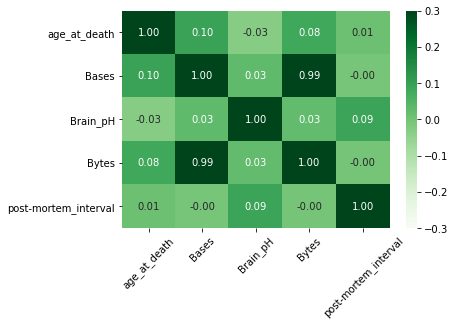

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
age_at_death,1.000,0.096,-0.029,0.081,0.011
Bases,0.096,1.000,0.030,0.992,-0.004
Brain_pH,-0.029,0.030,1.000,0.026,0.091
Bytes,0.081,0.992,0.026,1.000,-0.000
post-mortem_interval,0.011,-0.004,0.091,-0.000,1.000


In [47]:
corr_data = sra_data.corr()
sn.heatmap(corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
plt.show()

corr_data.round(3)

## MALE Subjects

In [8]:
sra_male = sra_data.loc[sra_data['gender']=='male']
sra_male.reset_index(drop=True)
sra_male

,Run,age_at_death,Bases,BioSample,Brain_pH,brain_region,Bytes,clinical_diagnosis,DATASTORE filetype,DATASTORE provider,DATASTORE region,ETHNICITY,Experiment,gender,GEO_Accession (exp),post-mortem_interval,ReleaseDate,Sample Name,source_name,SRA Study
0,SRR3438555,40,4177603300,SAMN04901133,6.76,AnCg,2585349730,Control,"fastq,sra","s3,ncbi,gs","ncbi.public,s3.us-east-1,gs.US",Caucasian,SRX1725699,male,GSM2132201,12.25,2017-06-25T00:00:00Z,GSM2132201,AnCg_Control,SRP073813
1,SRR3438556,58,4127971300,SAMN04901134,6.93,AnCg,2567182462,Major Depression,"fastq,sra","ncbi,s3,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725700,male,GSM2132202,24.00,2017-06-25T00:00:00Z,GSM2132202,AnCg_Major Depression,SRP073813
3,SRR3438558,49,3092070200,SAMN04901136,7.19,AnCg,1915194552,Major Depression,"fastq,sra","s3,gs,ncbi","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725702,male,GSM2132204,27.00,2017-06-25T00:00:00Z,GSM2132204,AnCg_Major Depression,SRP073813
5,SRR3438560,43,4971016500,SAMN04901138,7.10,nAcc,3231371785,Control,"fastq,sra","ncbi,s3,gs","ncbi.public,s3.us-east-1,gs.US",Asian,SRX1725704,male,GSM2132206,26.00,2017-06-25T00:00:00Z,GSM2132206,nAcc_Control,SRP073813
6,SRR3438561,45,5072000200,SAMN04901139,6.86,nAcc,3286118519,Control,"sra,fastq","ncbi,gs,s3","s3.us-east-1,ncbi.public,gs.US",Caucasian,SRX1725705,male,GSM2132207,21.00,2017-06-25T00:00:00Z,GSM2132207,nAcc_Control,SRP073813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,SRR3438899,40,7013314400,SAMN04900945,6.99,nAcc,4681158763,Major Depression,"sra,fastq","s3,ncbi,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725972,male,GSM2132474,24.00,2017-06-25T00:00:00Z,GSM2132474,nAcc_Major Depression,SRP073813
347,SRR3438902,36,6163667000,SAMN04900948,6.82,nAcc,4019800174,Schizophrenia,"sra,fastq","s3,ncbi,gs","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725975,male,GSM2132477,11.20,2017-06-25T00:00:00Z,GSM2132477,nAcc_Schizophrenia,SRP073813
348,SRR3438903,52,6037220400,SAMN04900949,6.89,nAcc,3972125530,Schizophrenia,"sra,fastq","s3,ncbi,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725976,male,GSM2132478,23.50,2017-06-25T00:00:00Z,GSM2132478,nAcc_Schizophrenia,SRP073813
349,SRR3438904,50,10491339100,SAMN04900950,6.64,nAcc,7155187185,Schizophrenia,"sra,fastq","ncbi,s3,gs","ncbi.public,gs.US,s3.us-east-1",Caucasian,SRX1725977,male,GSM2132479,25.70,2017-06-25T00:00:00Z,GSM2132479,nAcc_Schizophrenia,SRP073813


### Male Patient Description

In [9]:
sra_male.describe()

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
count,283.000000,2.830000e+02,280.000000,2.830000e+02,283.000000
mean,45.381625,5.624132e+09,6.907929,3.637616e+09,22.863251
std,12.842304,2.742268e+09,0.163845,1.805624e+09,7.506183
min,19.000000,1.700000e+03,6.520000,7.843400e+04,6.250000
25%,36.000000,2.884811e+09,6.805000,1.895940e+09,17.200000
50%,45.000000,5.742046e+09,6.910000,3.694134e+09,24.000000
75%,53.000000,7.917831e+09,7.022500,5.143306e+09,27.750000
max,70.000000,1.481045e+10,7.250000,9.987285e+09,44.250000


### Age at Death and Brain_pH Histogram

Text(0, 0.5, 'Frequency')

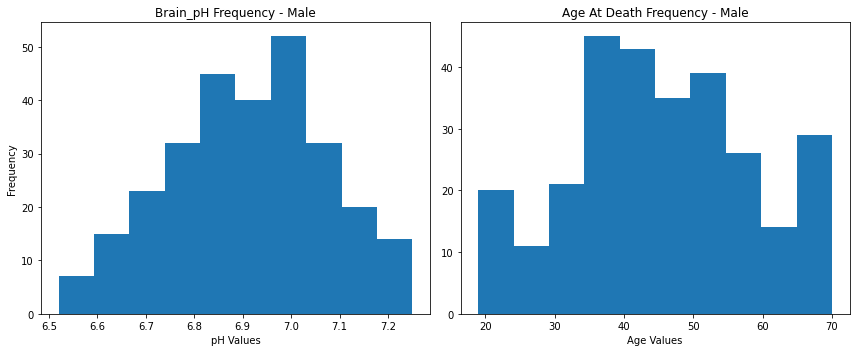

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

ax[0].hist(sra_male['Brain_pH'])
ax[1].hist(sra_male["age_at_death"])

ax[0].title.set_text("Brain_pH Frequency - Male")
ax[1].title.set_text("Age At Death Frequency - Male")

ax[0].set_xlabel("pH Values")
ax[1].set_xlabel("Age Values")

ax[0].set_ylabel("Frequency")
ax[0].set_ylabel("Frequency")


In [45]:
print(sra_male['age_at_death'].mean())
print(sra_female['Brain_pH'].mean())

45.381625441696116
6.870434782608693


### Age at Death Boxplot

Text(0.5, 0, 'Bipolar Disorder Patients')

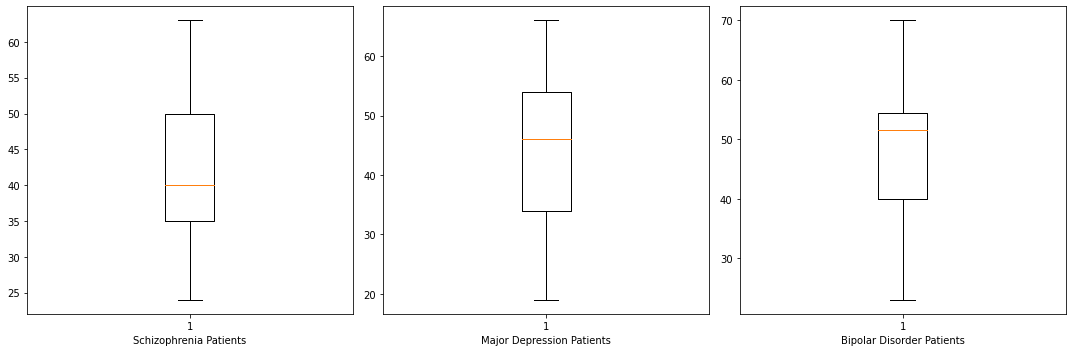

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,5),tight_layout=True)

male_scz = sra_male.loc[sra_male['clinical_diagnosis'] == 'Schizophrenia']
male_mdd = sra_male.loc[sra_male['clinical_diagnosis'] == 'Major Depression']
male_bpd = sra_male.loc[sra_male['clinical_diagnosis'] == 'Bipolar Disorder']
male_ctl = sra_male.loc[sra_male['clinical_diagnosis'] == 'Control']


ax[0].boxplot(male_scz['age_at_death'])
ax[1].boxplot(male_mdd['age_at_death'])
ax[2].boxplot(male_bpd['age_at_death'])

ax[0].set_xlabel("Schizophrenia Patients")
ax[1].set_xlabel("Major Depression Patients")
ax[2].set_xlabel("Bipolar Disorder Patients")


### Ethnicity Frequency

In [18]:
sra_male['ETHNICITY'].value_counts(normalize=True).round(3)

Caucasian           0.901
African American    0.032
Asian               0.028
Other               0.025
Pacific Islander    0.014
Name: ETHNICITY, dtype: float64

In [16]:
# Data Description broken down by Gender and Clinical Diagnosis
ethnicity_breakdown = sra_male.groupby(['ETHNICITY','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
ethnicity_breakdown

age_at_death  Brain_pH  \
ETHNICITY        clinical_diagnosis                           
African American Control                65.000000  6.880000   
                 Schizophrenia          39.000000  6.710000   
Asian            Control                43.000000  7.100000   
                 Schizophrenia          35.000000  6.610000   
Caucasian        Bipolar Disorder       48.946429  6.835357   
                 Control                47.731343  6.919104   
                 Major Depression       43.014085  7.027465   
                 Schizophrenia          42.114754  6.858793   
Other            Bipolar Disorder       49.000000  6.870000   
                 Schizophrenia          48.000000  6.930000   
Pacific Islander Control                39.000000  6.810000   

                                     post-mortem_interval  
ETHNICITY        clinical_diagnosis                        
African American Control                        13.500000  
                 Schizophrenia                  19.000000  
Asian            Control                        26.000000  
                 Schizophrenia                  26.500000  
Caucasian        Bipolar Disorder               22.358036  
                 Control                        23.057463  
                 Major Depression               25.949296  
                 Schizophrenia                  19.760656  
Other            Bipolar Disorder               29.500000  
                 Schizophrenia                  27.000000  
Pacific Islander Control                        18.150000

## Female Patients

In [19]:
sra_female = sra_data.loc[sra_data['gender']=='female']
sra_female.reset_index(drop=True)
sra_female

,Run,age_at_death,Bases,BioSample,Brain_pH,brain_region,Bytes,clinical_diagnosis,DATASTORE filetype,DATASTORE provider,DATASTORE region,ETHNICITY,Experiment,gender,GEO_Accession (exp),post-mortem_interval,ReleaseDate,Sample Name,source_name,SRA Study
2,SRR3438557,56,4323572800,SAMN04901135,6.83,AnCg,2690248610,Bipolar Disorder,"sra,fastq","gs,s3,ncbi","s3.us-east-1,gs.US,ncbi.public",Caucasian,SRX1725701,female,GSM2132203,29.00,2017-06-25T00:00:00Z,GSM2132203,AnCg_Bipolar Disorder,SRP073813
4,SRR3438559,31,5353395700,SAMN04901137,6.77,nAcc,3468863373,Schizophrenia,"fastq,sra","ncbi,s3,gs","gs.US,s3.us-east-1,ncbi.public",Caucasian,SRX1725703,female,GSM2132205,22.00,2017-06-25T00:00:00Z,GSM2132205,nAcc_Schizophrenia,SRP073813
7,SRR3438562,53,5066046600,SAMN04901140,6.78,nAcc,3295825555,Schizophrenia,"fastq,sra","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.US",Caucasian,SRX1725706,female,GSM2132208,34.00,2017-06-25T00:00:00Z,GSM2132208,nAcc_Schizophrenia,SRP073813
18,SRR3438573,48,2793975700,SAMN04901146,6.95,DLPFC,1816528639,Major Depression,"sra,fastq","ncbi,gs,s3","s3.us-east-1,ncbi.public,gs.US",Caucasian,SRX1725712,female,GSM2132214,37.00,2017-06-25T00:00:00Z,GSM2132214,DLPFC_Major Depression,SRP073813
19,SRR3438574,48,3024632800,SAMN04901146,6.95,DLPFC,2021573127,Major Depression,"sra,fastq","s3,ncbi,gs","s3.us-east-1,ncbi.public,gs.US",Caucasian,SRX1725712,female,GSM2132214,37.00,2017-06-25T00:00:00Z,GSM2132214,DLPFC_Major Depression,SRP073813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,SRR3438889,64,5966828100,SAMN04900977,6.83,AnCg,3992619598,Control,"fastq,sra","gs,ncbi,s3","s3.us-east-1,gs.US,ncbi.public",Caucasian,SRX1725962,female,GSM2132464,19.25,2017-06-25T00:00:00Z,GSM2132464,AnCg_Control,SRP073813
339,SRR3438894,53,6432719000,SAMN04900942,6.78,AnCg,4355243927,Schizophrenia,"fastq,sra","ncbi,s3,gs","ncbi.public,s3.us-east-1,gs.US",Caucasian,SRX1725967,female,GSM2132469,34.00,2017-06-25T00:00:00Z,GSM2132469,AnCg_Schizophrenia,SRP073813
345,SRR3438900,51,5973753000,SAMN04900946,6.81,AnCg,3955419172,Bipolar Disorder,"fastq,sra","gs,s3,ncbi","gs.US,ncbi.public,s3.us-east-1",Caucasian,SRX1725973,female,GSM2132475,16.80,2017-06-25T00:00:00Z,GSM2132475,AnCg_Bipolar Disorder,SRP073813
346,SRR3438901,49,6313386800,SAMN04900947,6.74,nAcc,4138790247,Bipolar Disorder,"fastq,sra","s3,ncbi,gs","s3.us-east-1,gs.US,ncbi.public",Caucasian,SRX1725974,female,GSM2132476,15.90,2017-06-25T00:00:00Z,GSM2132476,nAcc_Bipolar Disorder,SRP073813


### Female Patient Description

In [20]:
sra_female.describe()

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
count,69.000000,6.900000e+01,69.000000,6.900000e+01,69.000000
mean,50.681159,6.200840e+09,6.870435,4.021386e+09,22.680435
std,11.423007,2.539232e+09,0.215689,1.669016e+09,8.221686
min,25.000000,4.730000e+04,6.550000,1.117430e+05,7.600000
25%,46.000000,4.323573e+09,6.740000,2.656931e+09,16.800000
50%,51.000000,6.332934e+09,6.830000,4.157759e+09,22.000000
75%,58.000000,7.991907e+09,7.000000,5.178987e+09,28.000000
max,72.000000,1.040807e+10,7.390000,7.000601e+09,37.000000


### Age at Death and Brain_pH Histogram

Text(0, 0.5, 'Frequency')

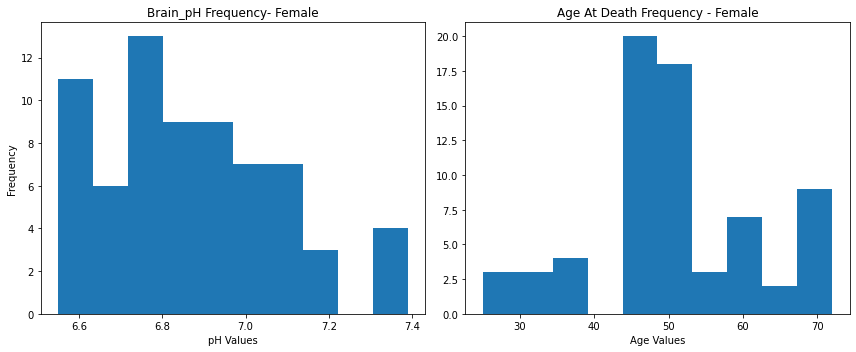

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

ax[0].hist(sra_female['Brain_pH'])
ax[1].hist(sra_female["age_at_death"])

ax[0].title.set_text("Brain_pH Frequency- Female")
ax[1].title.set_text("Age At Death Frequency - Female")

ax[0].set_xlabel("pH Values")
ax[1].set_xlabel("Age Values")

ax[0].set_ylabel("Frequency")
ax[0].set_ylabel("Frequency")

### Age at Death Boxplot

Text(0.5, 0, 'Bipolar Disorder Patients')

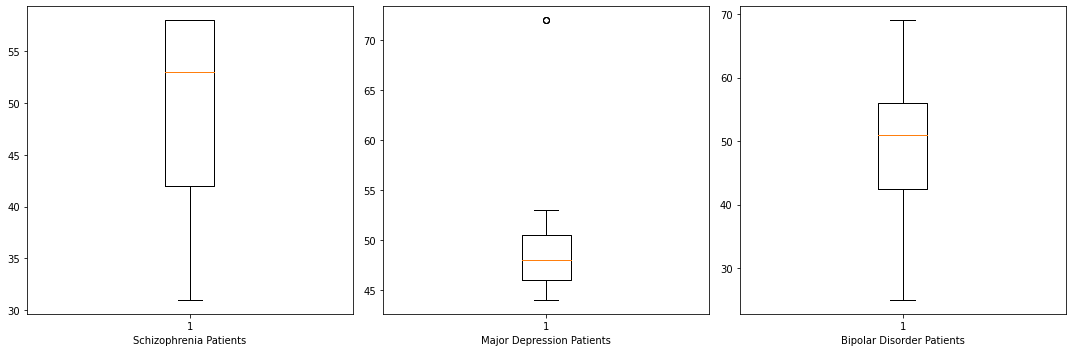

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,5),tight_layout=True)

female_scz = sra_female.loc[sra_female['clinical_diagnosis'] == 'Schizophrenia']
female_mdd = sra_female.loc[sra_female['clinical_diagnosis'] == 'Major Depression']
female_bpd = sra_female.loc[sra_female['clinical_diagnosis'] == 'Bipolar Disorder']
female_ctl = sra_female.loc[sra_female['clinical_diagnosis'] == 'Control']


ax[0].boxplot(female_scz['age_at_death'])
ax[1].boxplot(female_mdd['age_at_death'])
ax[2].boxplot(female_bpd['age_at_death'])

ax[0].set_xlabel("Schizophrenia Patients")
ax[1].set_xlabel("Major Depression Patients")
ax[2].set_xlabel("Bipolar Disorder Patients")


### Ethnicity Frequency

In [23]:
sra_female['ETHNICITY'].value_counts(normalize=True)

Caucasian    1.0
Name: ETHNICITY, dtype: float64

In [25]:
# Data Description broken down by Gender and Clinical Diagnosis
ethnicity_breakdown = sra_female.groupby(['ETHNICITY','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
ethnicity_breakdown.round(3)

age_at_death  Brain_pH  post-mortem_interval
ETHNICITY clinical_diagnosis                                              
Caucasian Bipolar Disorder          49.111     6.745                20.291
          Control                   59.125     6.939                18.500
          Major Depression          50.478     7.072                24.257
          Schizophrenia             48.818     6.708                28.291

### Unique Samples vs Duplicate Samples per Patient

1    212
2     67
3      2
Name: BioSample, dtype: int64

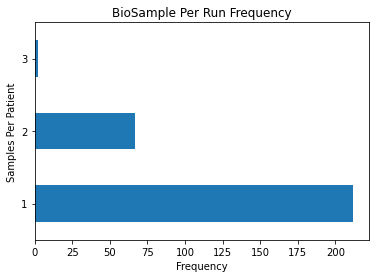

In [23]:
ax = sra_data["BioSample"].value_counts().value_counts().plot(kind='barh')
ax.set_xlabel("Frequency")
ax = ax.set_ylabel("Samples Per Patient")
plt.title("BioSample Per Run Frequency")

sra_data["BioSample"].value_counts().value_counts()

In [24]:
# Unique BioSample Data Brakedown
uniq_df = sra_data["BioSample"].value_counts().to_frame()
select_lst = uniq_df.loc[uniq_df['BioSample'] == 1]
select_lst = select_lst.index.to_list()
uniq_samp_df = sra_data[sra_data['BioSample'].isin(select_lst)]

# Data Description broken down by Gender and Clinical Diagnosis
gender_info_uniq = uniq_samp_df.groupby(['gender','clinical_diagnosis'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
gender_info_uniq = gender_info_uniq.unstack(level=0)
gender_info_uniq


age_at_death             Brain_pH            \
gender                   female       male    female      male   
clinical_diagnosis                                               
Bipolar Disorder      50.000000  47.205882  6.725238  6.874118   
Control               59.125000  50.533333  6.938750  6.916889   
Major Depression      52.928571  43.406250  7.071429  7.044375   
Schizophrenia         45.000000  42.549020  6.721429  6.864375   

                   post-mortem_interval             
gender                           female       male  
clinical_diagnosis                                  
Bipolar Disorder              21.183333  23.551471  
Control                       18.500000  21.814444  
Major Depression              21.978571  26.271875  
Schizophrenia                 26.942857  20.711765

## By Brain Region

In [25]:
nAcc_region = sra_data[sra_data['source_name'].str.contains("nAcc")]
DLPFC_region = sra_data[sra_data['source_name'].str.contains("DLPFC")]
AnCg_region = sra_data[sra_data['source_name'].str.contains("AnCg")]


In [26]:
# Averages broken down by source_name
region_info = sra_data.groupby(['source_name'])['age_at_death','Brain_pH','post-mortem_interval'].mean()
region_info

,age_at_death,Brain_pH,post-mortem_interval
source_name,,,
AnCg_Bipolar Disorder,47.642857,6.803214,22.119643
AnCg_Control,49.866667,6.924000,21.995000
AnCg_Major Depression,45.133333,7.047667,25.373333
AnCg_Schizophrenia,41.428571,6.811111,21.028571
DLPFC_Bipolar Disorder,49.428571,6.821071,22.705357
DLPFC_Control,47.766667,6.913667,21.850000
DLPFC_Major Depression,45.741935,7.038065,24.912903
DLPFC_Schizophrenia,43.275862,6.826429,21.317241
nAcc_Bipolar Disorder,49.838710,6.802903,21.380645


### Correlation Matrix Observations 

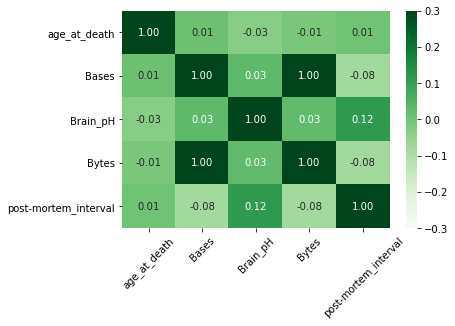

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
age_at_death,1.000000,0.010578,-0.030765,-0.009477,0.005116
Bases,0.010578,1.000000,0.032470,0.995112,-0.076484
Brain_pH,-0.030765,0.032470,1.000000,0.027210,0.115254
Bytes,-0.009477,0.995112,0.027210,1.000000,-0.077338
post-mortem_interval,0.005116,-0.076484,0.115254,-0.077338,1.000000


In [27]:
#nAcc
nAcc_corr_data = nAcc_region.corr()
sn.heatmap(nAcc_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
plt.show()

nAcc_corr_data

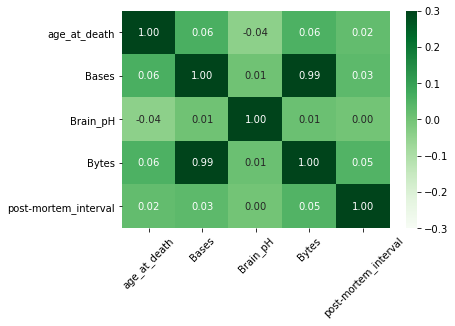

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
age_at_death,1.000000,0.061723,-0.042178,0.058535,0.024548
Bases,0.061723,1.000000,0.005854,0.990813,0.032847
Brain_pH,-0.042178,0.005854,1.000000,0.012579,0.000233
Bytes,0.058535,0.990813,0.012579,1.000000,0.050314
post-mortem_interval,0.024548,0.032847,0.000233,0.050314,1.000000


In [28]:
# DLPFC
DLPFC_corr_data = DLPFC_region.corr()
sn.heatmap(DLPFC_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
plt.show()

DLPFC_corr_data

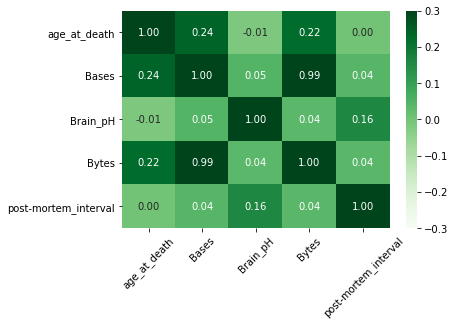

,age_at_death,Bases,Brain_pH,Bytes,post-mortem_interval
age_at_death,1.000000,0.243142,-0.014242,0.222711,0.003131
Bases,0.243142,1.000000,0.048963,0.990452,0.043760
Brain_pH,-0.014242,0.048963,1.000000,0.035977,0.160759
Bytes,0.222711,0.990452,0.035977,1.000000,0.038323
post-mortem_interval,0.003131,0.043760,0.160759,0.038323,1.000000


In [29]:
# AnCg
# Very Interesting Values
AnCg_corr_data = AnCg_region.corr()
sn.heatmap(AnCg_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-0.3, vmax=0.3)
plt.xticks(rotation=45)
plt.show()

AnCg_corr_data